# FineTuning NLP Models with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use the FLAML library to fine tune an NLP language model with hyperparameter search. We will use [flaml.tune](https://microsoft.github.io/FLAML/docs/Use-Cases/Tune-User-Defined-Function) with the built in GPU in colab for the tuning. However, if you have a machine with more than 1 GPU, you can also use FLAML's [parallel tuning](https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#parallel-tuning) with the ray tune option. 

FLAML requires `Python>=3.7`. To run this notebook example, please install flaml with the `[automl,hf,blendsearch]` option:
```bash
pip install flaml[automl,hf,blendsearch]; 
```

In [ ]:
%pip install flaml[automl,hf,blendsearch]
import flaml
flaml.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.4/250.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.0/159.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━

'1.2.0'

In [ ]:
%pip install transformers
%pip install datasets
%pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 30.3 MB/s eta 0:00:0

In [ ]:
import transformers
transformers.__version__

'4.27.4'

Let's run some examples. To use CoLab's built in GPU, you need to select Runtime -> Change runtime type and select GPU. Then you can print the device information using:

In [ ]:
import torch
print([torch.cuda.device(i) for i in range(torch.cuda.device_count())])

Note: throughout this notebook, you may see a few ModuleNotFoundErrors. As long as the cell successfully executes, you can ignore that error.

## 2. Sentiment Classification Example
### Load data and preprocess

The Stanford Sentiment treebank (SST-2) dataset is a dataset for sentiment classification. First, let's load this dataset into pandas dataframes:

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "sst2", split="train").to_pandas()
dev_dataset = load_dataset("glue", "sst2", split="validation").to_pandas()
test_dataset = load_dataset("glue", "sst2", split="test").to_pandas()

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


Take a look at the first 5 examples of this dataset:

In [ ]:
train_dataset.head(5)

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


Separate the data into X and y:

In [ ]:
custom_sent_keys = ["sentence"]          # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

### Run FLAML

Now we can run AutoML with FLAML:

In [ ]:
from flaml import AutoML
automl = AutoML()


Let's run FLAML for 30 mins. Here we use Electra's [small model](https://huggingface.co/google/electra-small-discriminator) for the tuning. We set gpu_per_trial to 1, and n_concurrent_trials to 1 (the number of trials running at the same time). Make sure gpu_per_trial * n_concurrent_trials does not exceed the GPU number you have. While running you can observe the resource usage (including the GPU) on the right. 

In [ ]:
MAX_ITER=20
automl_settings = {
    "max_iter": MAX_ITER,                  # setting the time budget
    "task": "seq-classification",       # setting the task as seq-classification
    "fit_kwargs_by_estimator": {
        "transformer": {
            "output_dir": "data/output/",   # setting the output directory
            "model_path": "google/electra-small-discriminator",  # if model_path is not set, the default model is facebook/muppet-roberta-base: https://huggingface.co/facebook/muppet-roberta-base
        }
    },
    "gpu_per_trial": 1,                 # using 1 GPU for each trial
    "log_file_name": "seqclass.log",    # set the file to save the log for HPO
    "log_type": "all",                  # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": False,                   # If parallel tuning, set "use_ray" to {"local_dir": "data/output/"}
    "n_concurrent_trials": 1,           # How many trials to run at the same time, n_concurrent_trials * gpu_per_trial must not exceed the total number of GPUs
    "keep_search_state": True,          # keeping the search state
  #  "fp16": False                       # whether to use fp16, this option is True by default. 
}

In [ ]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

[flaml.automl.logger: 04-12 02:51:07] {1768} INFO - task = seq-classification
[flaml.automl.logger: 04-12 02:51:07] {1775} INFO - Data split method: stratified
[flaml.automl.logger: 04-12 02:51:07] {1778} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-12 02:51:07] {1891} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 04-12 02:51:07] {2011} INFO - List of ML learners in AutoML Run: ['transformer']
[flaml.automl.logger: 04-12 02:51:07] {2341} INFO - iteration 0, current learner transformer


/usr/local/lib/python3.9/dist-packages/flaml/automl/data.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[str_columns] = X[str_columns].astype("string")


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5731, 'learning_rate': 4.6751863684771026e-06, 'epoch': 1.6}
{'eval_loss': 0.43649888038635254, 'eval_automl_metric': 0.1754587155963303, 'eval_runtime': 13.2765, 'eval_samples_per_second': 65.68, 'eval_steps_per_second': 65.68, 'epoch': 2.0}
{'eval_loss': 0.4060048460960388, 'eval_automl_metric': 0.16284403669724767, 'eval_runtime': 14.9968, 'eval_samples_per_second': 58.146, 'eval_steps_per_second': 58.146, 'epoch': 3.0}
{'train_runtime': 97.6411, 'train_samples_per_second': 307.248, 'train_steps_per_second': 9.617, 'train_loss': 0.4901065034226488, 'epoch': 3.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 02:53:14] {2479} INFO - Estimated sufficient time budget=67349s. Estimated necessary time budget=67s.
[flaml.automl.logger: 04-12 02:53:14] {2526} INFO -  at 127.6s,	estimator transformer's best error=0.1628,	best estimator transformer's best error=0.1628
[flaml.automl.logger: 04-12 02:53:14] {2341} INFO - iteration 1, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.4873640537261963, 'eval_automl_metric': 0.18463302752293576, 'eval_runtime': 13.2764, 'eval_samples_per_second': 65.681, 'eval_steps_per_second': 65.681, 'epoch': 2.0}
{'eval_loss': 0.4638785123825073, 'eval_automl_metric': 0.18119266055045868, 'eval_runtime': 13.1414, 'eval_samples_per_second': 66.355, 'eval_steps_per_second': 66.355, 'epoch': 3.0}
{'train_runtime': 71.0618, 'train_samples_per_second': 422.168, 'train_steps_per_second': 6.628, 'train_loss': 0.5612566192691746, 'epoch': 3.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 02:54:43] {2526} INFO -  at 217.2s,	estimator transformer's best error=0.1628,	best estimator transformer's best error=0.1628
[flaml.automl.logger: 04-12 02:54:43] {2341} INFO - iteration 2, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.5903, 'learning_rate': 7.550901222797876e-06, 'epoch': 0.8}
{'loss': 0.3877, 'learning_rate': 4.805118959962285e-06, 'epoch': 1.6}
{'eval_loss': 0.36965879797935486, 'eval_automl_metric': 0.1513761467889908, 'eval_runtime': 13.4161, 'eval_samples_per_second': 64.996, 'eval_steps_per_second': 64.996, 'epoch': 2.0}
{'loss': 0.3432, 'learning_rate': 2.0593366971266936e-06, 'epoch': 2.4}
{'eval_loss': 0.371982604265213, 'eval_automl_metric': 0.1513761467889908, 'eval_runtime': 13.2983, 'eval_samples_per_second': 65.572, 'eval_steps_per_second': 65.572, 'epoch': 3.0}
{'train_runtime': 135.4608, 'train_samples_per_second': 221.466, 'train_steps_per_second': 13.842, 'train_loss': 0.41677737223307293, 'epoch': 3.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 02:57:20] {2526} INFO -  at 373.7s,	estimator transformer's best error=0.1514,	best estimator transformer's best error=0.1514
[flaml.automl.logger: 04-12 02:57:20] {2341} INFO - iteration 3, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.5324, 'learning_rate': 8.879996750213199e-06, 'epoch': 0.8}
{'eval_loss': 0.383835107088089, 'eval_automl_metric': 0.15366972477064222, 'eval_runtime': 12.1911, 'eval_samples_per_second': 71.528, 'eval_steps_per_second': 71.528, 'epoch': 1.0}
{'loss': 0.3629, 'learning_rate': 2.959998916737733e-06, 'epoch': 1.6}
{'eval_loss': 0.3726535737514496, 'eval_automl_metric': 0.14678899082568808, 'eval_runtime': 12.3158, 'eval_samples_per_second': 70.803, 'eval_steps_per_second': 70.803, 'epoch': 2.0}
{'train_runtime': 97.7012, 'train_samples_per_second': 204.706, 'train_steps_per_second': 12.794, 'train_loss': 0.4241449279785156, 'epoch': 2.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 02:59:19] {2526} INFO -  at 493.1s,	estimator transformer's best error=0.1468,	best estimator transformer's best error=0.1468
[flaml.automl.logger: 04-12 02:59:19] {2341} INFO - iteration 4, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.505, 'learning_rate': 1.543094173639824e-05, 'epoch': 0.8}
{'eval_loss': 0.3837029039859772, 'eval_automl_metric': 0.16284403669724767, 'eval_runtime': 12.1657, 'eval_samples_per_second': 71.677, 'eval_steps_per_second': 71.677, 'epoch': 1.0}
{'loss': 0.334, 'learning_rate': 5.14364724546608e-06, 'epoch': 1.6}
{'eval_loss': 0.35917285084724426, 'eval_automl_metric': 0.14220183486238536, 'eval_runtime': 11.0611, 'eval_samples_per_second': 78.835, 'eval_steps_per_second': 78.835, 'epoch': 2.0}
{'train_runtime': 98.0782, 'train_samples_per_second': 203.919, 'train_steps_per_second': 12.745, 'train_loss': 0.3914005249023437, 'epoch': 2.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 03:01:16] {2526} INFO -  at 610.1s,	estimator transformer's best error=0.1422,	best estimator transformer's best error=0.1422
[flaml.automl.logger: 04-12 03:01:16] {2341} INFO - iteration 5, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.5324, 'learning_rate': 8.879996750213194e-06, 'epoch': 0.8}
{'eval_loss': 0.383835107088089, 'eval_automl_metric': 0.15366972477064222, 'eval_runtime': 12.2373, 'eval_samples_per_second': 71.257, 'eval_steps_per_second': 71.257, 'epoch': 1.0}
{'loss': 0.3629, 'learning_rate': 2.9599989167377317e-06, 'epoch': 1.6}
{'eval_loss': 0.3726535737514496, 'eval_automl_metric': 0.14678899082568808, 'eval_runtime': 15.0923, 'eval_samples_per_second': 57.778, 'eval_steps_per_second': 57.778, 'epoch': 2.0}
{'train_runtime': 96.9835, 'train_samples_per_second': 206.221, 'train_steps_per_second': 12.889, 'train_loss': 0.4241449279785156, 'epoch': 2.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 03:03:13] {2526} INFO -  at 726.6s,	estimator transformer's best error=0.1422,	best estimator transformer's best error=0.1422
[flaml.automl.logger: 04-12 03:03:13] {2341} INFO - iteration 6, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.4443, 'learning_rate': 3.3201834726658944e-05, 'epoch': 0.8}
{'eval_loss': 0.36218205094337463, 'eval_automl_metric': 0.14678899082568808, 'eval_runtime': 15.8225, 'eval_samples_per_second': 55.111, 'eval_steps_per_second': 55.111, 'epoch': 1.0}
{'loss': 0.2946, 'learning_rate': 1.106727824221965e-05, 'epoch': 1.6}
{'eval_loss': 0.3497363030910492, 'eval_automl_metric': 0.125, 'eval_runtime': 13.5632, 'eval_samples_per_second': 64.292, 'eval_steps_per_second': 64.292, 'epoch': 2.0}
{'train_runtime': 99.4348, 'train_samples_per_second': 201.137, 'train_steps_per_second': 12.571, 'train_loss': 0.34309757995605467, 'epoch': 2.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 03:05:13] {2526} INFO -  at 846.5s,	estimator transformer's best error=0.1250,	best estimator transformer's best error=0.1250
[flaml.automl.logger: 04-12 03:05:13] {2341} INFO - iteration 7, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.505, 'learning_rate': 1.543094173639823e-05, 'epoch': 0.8}
{'eval_loss': 0.3837029039859772, 'eval_automl_metric': 0.16284403669724767, 'eval_runtime': 13.2849, 'eval_samples_per_second': 65.639, 'eval_steps_per_second': 65.639, 'epoch': 1.0}
{'loss': 0.334, 'learning_rate': 5.143647245466077e-06, 'epoch': 1.6}
{'eval_loss': 0.35917285084724426, 'eval_automl_metric': 0.14220183486238536, 'eval_runtime': 13.3768, 'eval_samples_per_second': 65.187, 'eval_steps_per_second': 65.187, 'epoch': 2.0}
{'train_runtime': 100.6961, 'train_samples_per_second': 198.617, 'train_steps_per_second': 12.414, 'train_loss': 0.3914005249023437, 'epoch': 2.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 03:07:15] {2526} INFO -  at 969.1s,	estimator transformer's best error=0.1250,	best estimator transformer's best error=0.1250
[flaml.automl.logger: 04-12 03:07:15] {2341} INFO - iteration 8, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.4927, 'learning_rate': 4.960961475644055e-05, 'epoch': 0.4}
{'loss': 0.3649, 'learning_rate': 3.720721106733041e-05, 'epoch': 0.8}
{'eval_loss': 0.42004191875457764, 'eval_automl_metric': 0.14678899082568808, 'eval_runtime': 12.3779, 'eval_samples_per_second': 70.448, 'eval_steps_per_second': 70.448, 'epoch': 1.0}
{'loss': 0.3085, 'learning_rate': 2.4804807378220275e-05, 'epoch': 1.2}
{'loss': 0.2846, 'learning_rate': 1.2402403689110137e-05, 'epoch': 1.6}
{'loss': 0.2478, 'learning_rate': 0.0, 'epoch': 2.0}
{'eval_loss': 0.4621019959449768, 'eval_automl_metric': 0.13188073394495414, 'eval_runtime': 15.9671, 'eval_samples_per_second': 54.612, 'eval_steps_per_second': 54.612, 'epoch': 2.0}
{'train_runtime': 176.8274, 'train_samples_per_second': 113.105, 'train_steps_per_second': 14.138, 'train_loss': 0.3397238067626953, 'epoch': 2.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 03:10:32] {2526} INFO -  at 1166.1s,	estimator transformer's best error=0.1250,	best estimator transformer's best error=0.1250
[flaml.automl.logger: 04-12 03:10:32] {2341} INFO - iteration 9, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.38070234656333923, 'eval_automl_metric': 0.1571100917431193, 'eval_runtime': 13.2262, 'eval_samples_per_second': 65.93, 'eval_steps_per_second': 65.93, 'epoch': 1.0}
{'loss': 0.3891, 'learning_rate': 9.938984432909045e-06, 'epoch': 1.6}
{'eval_loss': 0.3584316074848175, 'eval_automl_metric': 0.1490825688073395, 'eval_runtime': 12.9432, 'eval_samples_per_second': 67.371, 'eval_steps_per_second': 67.371, 'epoch': 2.0}
{'train_runtime': 67.7566, 'train_samples_per_second': 295.174, 'train_steps_per_second': 9.239, 'train_loss': 0.36350049149875824, 'epoch': 2.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 03:12:00] {2526} INFO -  at 1253.6s,	estimator transformer's best error=0.1250,	best estimator transformer's best error=0.1250
[flaml.automl.logger: 04-12 03:12:00] {2341} INFO - iteration 10, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.4701, 'learning_rate': 2.245453717937598e-05, 'epoch': 0.8}
{'eval_loss': 0.333243191242218, 'eval_automl_metric': 0.1330275229357798, 'eval_runtime': 13.3288, 'eval_samples_per_second': 65.422, 'eval_steps_per_second': 65.422, 'epoch': 1.0}
{'loss': 0.3064, 'learning_rate': 7.484845726458661e-06, 'epoch': 1.6}
{'eval_loss': 0.3158172369003296, 'eval_automl_metric': 0.12958715596330272, 'eval_runtime': 13.0704, 'eval_samples_per_second': 66.716, 'eval_steps_per_second': 66.716, 'epoch': 2.0}
{'train_runtime': 100.5144, 'train_samples_per_second': 198.977, 'train_steps_per_second': 12.436, 'train_loss': 0.3659558166503906, 'epoch': 2.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 03:14:03] {2526} INFO -  at 1376.9s,	estimator transformer's best error=0.1250,	best estimator transformer's best error=0.1250
[flaml.automl.logger: 04-12 03:14:03] {2341} INFO - iteration 11, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.4463, 'learning_rate': 5.205038223181688e-05, 'epoch': 0.12}
{'loss': 0.318, 'learning_rate': 4.876437325253551e-05, 'epoch': 0.24}
{'loss': 0.2922, 'learning_rate': 4.547836427325414e-05, 'epoch': 0.36}
{'loss': 0.2593, 'learning_rate': 4.219235529397277e-05, 'epoch': 0.48}
{'loss': 0.2689, 'learning_rate': 3.8906346314691405e-05, 'epoch': 0.59}
{'loss': 0.2379, 'learning_rate': 3.5620337335410034e-05, 'epoch': 0.71}
{'loss': 0.2362, 'learning_rate': 3.233432835612866e-05, 'epoch': 0.83}
{'loss': 0.2216, 'learning_rate': 2.9048319376847296e-05, 'epoch': 0.95}
{'eval_loss': 0.30998706817626953, 'eval_automl_metric': 0.10550458715596334, 'eval_runtime': 13.4979, 'eval_samples_per_second': 64.603, 'eval_steps_per_second': 64.603, 'epoch': 1.0}
{'loss': 0.195, 'learning_rate': 2.5762310397565928e-05, 'epoch': 1.07}
{'loss': 0.1818, 'learning_rate': 2.247630141828456e-05, 'epoch': 1.19}
{'loss': 0.1702, 'learning_rate': 1.919029243900319e-05, 'epoch': 1.31}
{'loss': 0.1764, 'lea

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 03:23:26] {2526} INFO -  at 1939.6s,	estimator transformer's best error=0.0998,	best estimator transformer's best error=0.0998
[flaml.automl.logger: 04-12 03:23:26] {2341} INFO - iteration 12, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.4977, 'learning_rate': 2.4827832220147736e-05, 'epoch': 0.12}
{'loss': 0.3577, 'learning_rate': 2.3260418569885886e-05, 'epoch': 0.24}
{'loss': 0.298, 'learning_rate': 2.169300491962403e-05, 'epoch': 0.36}
{'loss': 0.2778, 'learning_rate': 2.0125591269362177e-05, 'epoch': 0.48}
{'loss': 0.2768, 'learning_rate': 1.8558177619100327e-05, 'epoch': 0.59}
{'loss': 0.2563, 'learning_rate': 1.6990763968838476e-05, 'epoch': 0.71}
{'loss': 0.2446, 'learning_rate': 1.5423350318576622e-05, 'epoch': 0.83}
{'loss': 0.2298, 'learning_rate': 1.3855936668314771e-05, 'epoch': 0.95}
{'eval_loss': 0.24045641720294952, 'eval_automl_metric': 0.08371559633027525, 'eval_runtime': 13.5012, 'eval_samples_per_second': 64.587, 'eval_steps_per_second': 64.587, 'epoch': 1.0}
{'loss': 0.2207, 'learning_rate': 1.2288523018052919e-05, 'epoch': 1.07}
{'loss': 0.1969, 'learning_rate': 1.0721109367791068e-05, 'epoch': 1.19}
{'loss': 0.1994, 'learning_rate': 9.153695717529216e-06, 'epoch': 1.31}
{'loss': 0.1888

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 03:32:50] {2526} INFO -  at 2503.4s,	estimator transformer's best error=0.0837,	best estimator transformer's best error=0.0837
[flaml.automl.logger: 04-12 03:32:50] {2341} INFO - iteration 13, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.4506, 'learning_rate': 1.9036634605968542e-05, 'epoch': 0.24}
{'loss': 0.3162, 'learning_rate': 1.6471050427266582e-05, 'epoch': 0.48}
{'loss': 0.283, 'learning_rate': 1.3905466248564623e-05, 'epoch': 0.71}
{'loss': 0.2499, 'learning_rate': 1.1339882069862663e-05, 'epoch': 0.95}
{'eval_loss': 0.2961079776287079, 'eval_automl_metric': 0.12041284403669728, 'eval_runtime': 11.8342, 'eval_samples_per_second': 73.685, 'eval_steps_per_second': 73.685, 'epoch': 1.0}
{'loss': 0.2234, 'learning_rate': 8.774297891160704e-06, 'epoch': 1.19}
{'loss': 0.2074, 'learning_rate': 6.208713712458743e-06, 'epoch': 1.43}
{'loss': 0.1995, 'learning_rate': 3.6431295337567835e-06, 'epoch': 1.66}
{'loss': 0.2037, 'learning_rate': 1.077545355054823e-06, 'epoch': 1.9}
{'eval_loss': 0.2587985694408417, 'eval_automl_metric': 0.09174311926605505, 'eval_runtime': 13.0236, 'eval_samples_per_second': 66.955, 'eval_steps_per_second': 66.955, 'epoch': 2.0}
{'train_runtime': 303.3583, 'train_samples_per_second

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 03:38:27] {2526} INFO -  at 2840.5s,	estimator transformer's best error=0.0837,	best estimator transformer's best error=0.0837
[flaml.automl.logger: 04-12 03:38:27] {2341} INFO - iteration 14, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.5133, 'learning_rate': 3.1294026779419606e-05, 'epoch': 0.06}
{'loss': 0.3967, 'learning_rate': 3.0336319998313606e-05, 'epoch': 0.12}
{'loss': 0.3755, 'learning_rate': 2.9378613217207605e-05, 'epoch': 0.18}
{'loss': 0.3482, 'learning_rate': 2.842090643610161e-05, 'epoch': 0.24}
{'loss': 0.3325, 'learning_rate': 2.7463199654995608e-05, 'epoch': 0.3}
{'loss': 0.3393, 'learning_rate': 2.6505492873889615e-05, 'epoch': 0.36}
{'loss': 0.2998, 'learning_rate': 2.5547786092783614e-05, 'epoch': 0.42}
{'loss': 0.3135, 'learning_rate': 2.4590079311677617e-05, 'epoch': 0.48}
{'loss': 0.3285, 'learning_rate': 2.3632372530571617e-05, 'epoch': 0.53}
{'loss': 0.3231, 'learning_rate': 2.267466574946562e-05, 'epoch': 0.59}
{'loss': 0.2747, 'learning_rate': 2.171695896835962e-05, 'epoch': 0.65}
{'loss': 0.3021, 'learning_rate': 2.0759252187253623e-05, 'epoch': 0.71}
{'loss': 0.3086, 'learning_rate': 1.9801545406147622e-05, 'epoch': 0.77}
{'loss': 0.2598, 'learning_rate': 1.8843838625041625e-0

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 03:55:51] {2526} INFO -  at 3884.8s,	estimator transformer's best error=0.0837,	best estimator transformer's best error=0.0837
[flaml.automl.logger: 04-12 03:55:51] {2341} INFO - iteration 15, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.5456, 'learning_rate': 1.4204334325441244e-05, 'epoch': 0.12}
{'loss': 0.3467, 'learning_rate': 1.2290003553818434e-05, 'epoch': 0.24}
{'loss': 0.3331, 'learning_rate': 1.0375672782195626e-05, 'epoch': 0.36}
{'loss': 0.3057, 'learning_rate': 8.461342010572816e-06, 'epoch': 0.48}
{'loss': 0.291, 'learning_rate': 6.547011238950007e-06, 'epoch': 0.59}
{'loss': 0.2872, 'learning_rate': 4.632680467327198e-06, 'epoch': 0.71}
{'loss': 0.2688, 'learning_rate': 2.718349695704389e-06, 'epoch': 0.83}
{'loss': 0.2666, 'learning_rate': 8.040189240815798e-07, 'epoch': 0.95}
{'eval_loss': 0.2697773277759552, 'eval_automl_metric': 0.10206422018348627, 'eval_runtime': 13.1895, 'eval_samples_per_second': 66.113, 'eval_steps_per_second': 66.113, 'epoch': 1.0}
{'train_runtime': 256.8129, 'train_samples_per_second': 262.249, 'train_steps_per_second': 16.393, 'train_loss': 0.32819755354856367, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 04:00:45] {2526} INFO -  at 4178.9s,	estimator transformer's best error=0.0837,	best estimator transformer's best error=0.0837
[flaml.automl.logger: 04-12 04:00:45] {2341} INFO - iteration 16, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.4628, 'learning_rate': 4.151258730652502e-05, 'epoch': 0.12}
{'loss': 0.3132, 'learning_rate': 3.980143366651987e-05, 'epoch': 0.24}
{'loss': 0.2997, 'learning_rate': 3.8090280026514715e-05, 'epoch': 0.36}
{'loss': 0.2644, 'learning_rate': 3.637912638650956e-05, 'epoch': 0.48}
{'loss': 0.2709, 'learning_rate': 3.4667972746504405e-05, 'epoch': 0.59}
{'loss': 0.2412, 'learning_rate': 3.2956819106499256e-05, 'epoch': 0.71}
{'loss': 0.2422, 'learning_rate': 3.12456654664941e-05, 'epoch': 0.83}
{'loss': 0.2258, 'learning_rate': 2.953451182648895e-05, 'epoch': 0.95}
{'loss': 0.2074, 'learning_rate': 2.7823358186483794e-05, 'epoch': 1.07}
{'loss': 0.1859, 'learning_rate': 2.6112204546478642e-05, 'epoch': 1.19}
{'loss': 0.1871, 'learning_rate': 2.4401050906473487e-05, 'epoch': 1.31}
{'loss': 0.1918, 'learning_rate': 2.268989726646833e-05, 'epoch': 1.43}
{'loss': 0.1836, 'learning_rate': 2.097874362646318e-05, 'epoch': 1.54}
{'loss': 0.1776, 'learning_rate': 1.9267589986458028e-05, '

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 04:14:05] {2526} INFO -  at 4978.9s,	estimator transformer's best error=0.0837,	best estimator transformer's best error=0.0837
[flaml.automl.logger: 04-12 04:14:05] {2341} INFO - iteration 17, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.4976, 'learning_rate': 2.4804708485734894e-05, 'epoch': 0.12}
{'loss': 0.3505, 'learning_rate': 2.3782255539084654e-05, 'epoch': 0.24}
{'loss': 0.3027, 'learning_rate': 2.275980259243441e-05, 'epoch': 0.36}
{'loss': 0.2787, 'learning_rate': 2.1737349645784163e-05, 'epoch': 0.48}
{'loss': 0.2575, 'learning_rate': 2.0714896699133923e-05, 'epoch': 0.59}
{'loss': 0.2483, 'learning_rate': 1.969244375248368e-05, 'epoch': 0.71}
{'loss': 0.2386, 'learning_rate': 1.8669990805833436e-05, 'epoch': 0.83}
{'loss': 0.2348, 'learning_rate': 1.7647537859183196e-05, 'epoch': 0.95}
{'loss': 0.2039, 'learning_rate': 1.6625084912532952e-05, 'epoch': 1.07}
{'loss': 0.1986, 'learning_rate': 1.560263196588271e-05, 'epoch': 1.19}
{'loss': 0.1961, 'learning_rate': 1.4580179019232463e-05, 'epoch': 1.31}
{'loss': 0.1901, 'learning_rate': 1.3557726072582221e-05, 'epoch': 1.43}
{'loss': 0.1992, 'learning_rate': 1.253527312593198e-05, 'epoch': 1.54}
{'loss': 0.1824, 'learning_rate': 1.1512820179281736e-0

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 04:27:21] {2526} INFO -  at 5775.1s,	estimator transformer's best error=0.0837,	best estimator transformer's best error=0.0837
[flaml.automl.logger: 04-12 04:27:21] {2341} INFO - iteration 18, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.485, 'learning_rate': 2.377204590632704e-05, 'epoch': 0.12}
{'loss': 0.3523, 'learning_rate': 2.0568266134584853e-05, 'epoch': 0.24}
{'loss': 0.3008, 'learning_rate': 1.7364486362842665e-05, 'epoch': 0.36}
{'loss': 0.281, 'learning_rate': 1.4160706591100473e-05, 'epoch': 0.48}
{'loss': 0.2656, 'learning_rate': 1.0956926819358287e-05, 'epoch': 0.59}
{'loss': 0.26, 'learning_rate': 7.753147047616097e-06, 'epoch': 0.71}
{'loss': 0.245, 'learning_rate': 4.5493672758739085e-06, 'epoch': 0.83}
{'loss': 0.248, 'learning_rate': 1.3455875041317192e-06, 'epoch': 0.95}
{'eval_loss': 0.26702097058296204, 'eval_automl_metric': 0.09518348623853212, 'eval_runtime': 12.5875, 'eval_samples_per_second': 69.275, 'eval_steps_per_second': 69.275, 'epoch': 1.0}
{'train_runtime': 258.5842, 'train_samples_per_second': 260.453, 'train_steps_per_second': 16.281, 'train_loss': 0.3011425933475449, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 04:32:15] {2526} INFO -  at 6068.8s,	estimator transformer's best error=0.0837,	best estimator transformer's best error=0.0837
[flaml.automl.logger: 04-12 04:32:15] {2341} INFO - iteration 19, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.4688, 'learning_rate': 2.860547592162196e-05, 'epoch': 0.12}
{'loss': 0.3323, 'learning_rate': 2.679957466394381e-05, 'epoch': 0.24}
{'loss': 0.3065, 'learning_rate': 2.4993673406265652e-05, 'epoch': 0.36}
{'loss': 0.2827, 'learning_rate': 2.3187772148587497e-05, 'epoch': 0.48}
{'loss': 0.2619, 'learning_rate': 2.1381870890909346e-05, 'epoch': 0.59}
{'loss': 0.2546, 'learning_rate': 1.957596963323119e-05, 'epoch': 0.71}
{'loss': 0.2411, 'learning_rate': 1.7770068375553037e-05, 'epoch': 0.83}
{'loss': 0.2373, 'learning_rate': 1.5964167117874882e-05, 'epoch': 0.95}
{'eval_loss': 0.2775367200374603, 'eval_automl_metric': 0.09403669724770647, 'eval_runtime': 13.3919, 'eval_samples_per_second': 65.114, 'eval_steps_per_second': 65.114, 'epoch': 1.0}
{'loss': 0.2111, 'learning_rate': 1.415826586019673e-05, 'epoch': 1.07}
{'loss': 0.2022, 'learning_rate': 1.2352364602518575e-05, 'epoch': 1.19}
{'loss': 0.1888, 'learning_rate': 1.054646334484042e-05, 'epoch': 1.31}
{'loss': 0.1875, '

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 04:41:42] {2526} INFO -  at 6635.5s,	estimator transformer's best error=0.0837,	best estimator transformer's best error=0.0837
[flaml.automl.logger: 04-12 04:41:42] {2642} INFO - selected model: None
[flaml.automl.logger: 04-12 04:41:42] {2041} INFO - fit succeeded
[flaml.automl.logger: 04-12 04:41:42] {2042} INFO - Time taken to find the best model: 2503.373429775238


The run takes 2.5 hours. We can print the best trial's loss, which is 1-the accuracy. The accuracy we got is 90.9% which is close to 91.2% reported by [the Electra model github](https://github.com/google-research/electra). 

In [ ]:
print("The best loss by FLAML: {}".format(1-automl.best_loss))

The best loss by FLAML: 0.9162844036697247


If you have more GPUs on your server, you can use flaml.tune with the ray tune option, which will often give you a better score. For example, with 4x NVIDIA V100 GPU, the accuracy was 92.2% after searching for half an hour. For that experiment, you can open this notebook on your GPU server and set "use_ray" to {"local_dir": "data/output/"} and n_concurrent_trials to more than 1. 

### Best model and metric

Next, we can print the best hyperparameter and the best score:

In [ ]:
'''retrieve best config and best learner'''
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'learning_rate': 2.6395245870409587e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'seed': 33, 'global_max_steps': 4210}
Best accuracy on validation data: 0.9163
Training duration of best run: 563.8 s


Save and load the model:

In [ ]:
import pickle
automl.pickle("automl.pkl")

with open("automl.pkl", "rb") as f:
    automl = pickle.load(f)

Run the prediction:




In [ ]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_val, **{"per_device_eval_batch_size": 1})
print('Predicted labels', y_pred)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Predicted labels [1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1
 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0
 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0
 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0
 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0
 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0
 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0
 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1
 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1
 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1
 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1
 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 1
 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1
 1 1 1 1

### Log history

You can also save and plot the history:

In [ ]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'seed': 20, 'global_max_steps': 939, 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'seed': 20, 'global_max_steps': 939, 'FLAML_sample_size': 10000}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 9.711865003865157e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 64, 'seed': 14, 'global_max_steps': 471, 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'seed': 20, 'global_max_steps': 939, 'FLAML_sample_size': 10000}}
{'Current Learner': 'transformer', 'Current Sample':

14


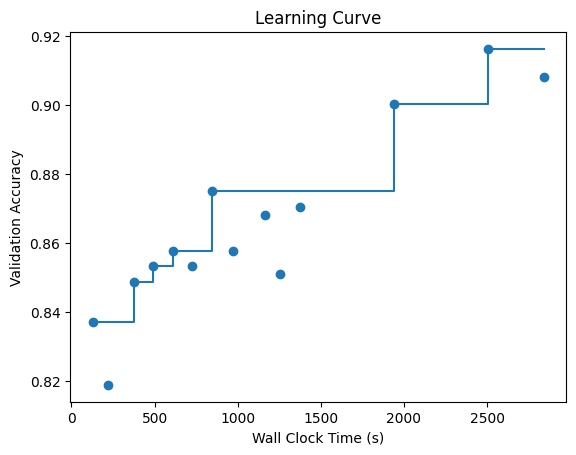

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Model selection

Given a dataset, which language model should you use for the fine tuning? It appears this is a simple question: just choose the best model according to the benchmarks such as [GLUE](https://gluebenchmark.com/leaderboard). However, we will see that under the resource constraints, the model selection is non trivial. 

In this example, we will tune the [spooky-author-identification](https://www.kaggle.com/competitions/spooky-author-identification/data?select=train.zip) dataset from kaggle. You can download the dataset from the [here](https://drive.google.com/file/d/1Jk-_Vg_SxOUDfFVzF7S85oBasY8fFvOY/view?usp=sharing) and upload it to Colab. The following command also downloads the file. We run FLAML for 30 mins using bert.

In [ ]:
!gdown 1Jk-_Vg_SxOUDfFVzF7S85oBasY8fFvOY

Downloading...
From: https://drive.google.com/uc?id=1Jk-_Vg_SxOUDfFVzF7S85oBasY8fFvOY
To: /content/spooky-author-identification.csv

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 79.7MB/s]


In [ ]:
from flaml import AutoML
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/spooky-author-identification.csv')
X, y = df.drop('author', axis=1), df['author']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)
automl_model = AutoML()

automl_settings = {
    "time_budget": 1800,                 
    "task": "seq-classification",       
    "fit_kwargs_by_estimator": {
        "transformer": {
            "output_dir": "data/output/",   
            "model_path": "bert-base-uncased",  
        }
    },
    "metric": "accuracy",
    "gpu_per_trial": 1,  
    "log_file_name": "spooky_bert.log", 
    "log_type": "all",                 
    "use_ray": False,                    # set whether to use Ray
    "n_concurrent_trials": 1,
    "keep_search_state": True,          # keeping the search state
}

from flaml import tune
custom_hp = {
    "transformer": {
            "num_train_epochs": {
                "domain": tune.choice([0.3, 1, 2, 3, 4, 5]),
                "init_value": 0.3,  
                "low_cost_init_value": 0.3,
            },
        }
}

automl_model.fit(X_train=X_train, y_train=y_train,X_val=X_val, y_val=y_val, custom_hp=custom_hp, **automl_settings)

[flaml.automl.logger: 04-12 17:19:25] {1768} INFO - task = seq-classification
[flaml.automl.logger: 04-12 17:19:25] {1775} INFO - Data split method: stratified
[flaml.automl.logger: 04-12 17:19:25] {1778} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-12 17:19:25] {1891} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 04-12 17:19:25] {2011} INFO - List of ML learners in AutoML Run: ['transformer']
[flaml.automl.logger: 04-12 17:19:25] {2341} INFO - iteration 0, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.8885396122932434, 'eval_automl_metric': 0.3881511746680286, 'eval_runtime': 63.5955, 'eval_samples_per_second': 76.971, 'eval_steps_per_second': 76.971, 'epoch': 0.3}
{'train_runtime': 138.5184, 'train_samples_per_second': 31.802, 'train_steps_per_second': 0.996, 'train_loss': 0.9821738643922667, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 17:23:29] {2479} INFO - Estimated sufficient time budget=2440736s. Estimated necessary time budget=2441s.
[flaml.automl.logger: 04-12 17:23:29] {2526} INFO -  at 244.1s,	estimator transformer's best error=0.3882,	best estimator transformer's best error=0.3882
[flaml.automl.logger: 04-12 17:23:29] {2341} INFO - iteration 1, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.9504787921905518, 'eval_automl_metric': 0.454341164453524, 'eval_runtime': 63.833, 'eval_samples_per_second': 76.685, 'eval_steps_per_second': 76.685, 'epoch': 0.3}
{'train_runtime': 143.6886, 'train_samples_per_second': 30.658, 'train_steps_per_second': 0.48, 'train_loss': 1.0153502312259397, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 17:27:17] {2526} INFO -  at 472.5s,	estimator transformer's best error=0.3882,	best estimator transformer's best error=0.3882
[flaml.automl.logger: 04-12 17:27:17] {2341} INFO - iteration 2, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.7725200057029724, 'eval_automl_metric': 0.31624106230847804, 'eval_runtime': 64.172, 'eval_samples_per_second': 76.279, 'eval_steps_per_second': 76.279, 'epoch': 0.3}
{'train_runtime': 136.3992, 'train_samples_per_second': 32.296, 'train_steps_per_second': 2.023, 'train_loss': 0.9211070848547894, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 17:30:57] {2526} INFO -  at 691.8s,	estimator transformer's best error=0.3162,	best estimator transformer's best error=0.3162
[flaml.automl.logger: 04-12 17:30:57] {2341} INFO - iteration 3, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.7185199856758118, 'eval_automl_metric': 0.2858018386108274, 'eval_runtime': 63.1708, 'eval_samples_per_second': 77.488, 'eval_steps_per_second': 77.488, 'epoch': 0.3}
{'train_runtime': 136.3072, 'train_samples_per_second': 32.318, 'train_steps_per_second': 2.025, 'train_loss': 0.8806653230086617, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 17:34:34] {2526} INFO -  at 908.9s,	estimator transformer's best error=0.2858,	best estimator transformer's best error=0.2858
[flaml.automl.logger: 04-12 17:34:34] {2341} INFO - iteration 4, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.7593, 'learning_rate': 4.688468079515019e-06, 'epoch': 0.54}
{'eval_loss': 0.48282745480537415, 'eval_automl_metric': 0.18263534218590394, 'eval_runtime': 62.0311, 'eval_samples_per_second': 78.912, 'eval_steps_per_second': 78.912, 'epoch': 1.0}
{'train_runtime': 299.9815, 'train_samples_per_second': 48.95, 'train_steps_per_second': 3.06, 'train_loss': 0.6506855950116591, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 17:40:55] {2526} INFO -  at 1289.8s,	estimator transformer's best error=0.1826,	best estimator transformer's best error=0.1826
[flaml.automl.logger: 04-12 17:40:55] {2341} INFO - iteration 5, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.6676, 'learning_rate': 8.147241469004167e-06, 'epoch': 0.54}
{'eval_loss': 0.3991524279117584, 'eval_automl_metric': 0.1542390194075587, 'eval_runtime': 61.4178, 'eval_samples_per_second': 79.7, 'eval_steps_per_second': 79.7, 'epoch': 1.0}
{'train_runtime': 299.7831, 'train_samples_per_second': 48.982, 'train_steps_per_second': 3.062, 'train_loss': 0.5576270442123247, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 17:47:16] {2526} INFO -  at 1671.6s,	estimator transformer's best error=0.1542,	best estimator transformer's best error=0.1542
[flaml.automl.logger: 04-12 17:47:16] {2642} INFO - selected model: None
[flaml.automl.logger: 04-12 17:47:16] {2041} INFO - fit succeeded
[flaml.automl.logger: 04-12 17:47:16] {2042} INFO - Time taken to find the best model: 1671.5927600860596
[flaml.automl.logger: 04-12 17:47:16] {2054} WARNING - Time taken to find the best model is 93% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


The job ran for 23m and searched for 4 trials. This time is shorter than our budget 30m because FLAML early stops the last trial which will run for too long. If you want to run for longer time, set a larger time budget. 

In [ ]:
print("the best loss for spooky author identification: {}".format(automl_model.best_loss))

the best loss for spooky author identification: 0.1542390194075587


Next, we set the model to roberta and run again. RoBERTa outperforms BERT by 15% on the [SuperGLUE](https://super.gluebenchmark.com/) benchmark, as well as [GLUE](https://gluebenchmark.com/), [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/), [RACE](https://www.cs.cmu.edu/~glai1/data/race/), etc. Does this mean we should always use RoBERTa and never use BERT? To answer this question, we run the same experiment again with RoBERTa:

In [ ]:
automl_settings["fit_kwargs_by_estimator"]["transformer"]["model_path"] = "roberta-base"
automl_settings["log_file_name"] = "spooky_roberta.log"
automl_model.fit(X_train=X_train, y_train=y_train,X_val=X_val, y_val=y_val, custom_hp=custom_hp, **automl_settings)

[flaml.automl.logger: 04-12 17:48:38] {1768} INFO - task = seq-classification
[flaml.automl.logger: 04-12 17:48:38] {1775} INFO - Data split method: stratified
[flaml.automl.logger: 04-12 17:48:38] {1778} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-12 17:48:38] {1891} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 04-12 17:48:38] {2011} INFO - List of ML learners in AutoML Run: ['transformer']
[flaml.automl.logger: 04-12 17:48:38] {2341} INFO - iteration 0, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.8735764622688293, 'eval_automl_metric': 0.34811031664964254, 'eval_runtime': 62.4127, 'eval_samples_per_second': 78.43, 'eval_steps_per_second': 78.43, 'epoch': 0.3}
{'train_runtime': 141.5981, 'train_samples_per_second': 31.111, 'train_steps_per_second': 0.975, 'train_loss': 1.0305425671563633, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 17:52:30] {2479} INFO - Estimated sufficient time budget=2324423s. Estimated necessary time budget=2324s.
[flaml.automl.logger: 04-12 17:52:30] {2526} INFO -  at 232.6s,	estimator transformer's best error=0.3481,	best estimator transformer's best error=0.3481
[flaml.automl.logger: 04-12 17:52:30] {2341} INFO - iteration 1, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 1.0598695278167725, 'eval_automl_metric': 0.6020429009193053, 'eval_runtime': 61.0626, 'eval_samples_per_second': 80.164, 'eval_steps_per_second': 80.164, 'epoch': 0.3}
{'train_runtime': 138.5775, 'train_samples_per_second': 31.789, 'train_steps_per_second': 0.498, 'train_loss': 1.0830751501995584, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 17:56:12] {2526} INFO -  at 454.0s,	estimator transformer's best error=0.3481,	best estimator transformer's best error=0.3481
[flaml.automl.logger: 04-12 17:56:12] {2341} INFO - iteration 2, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.6515682339668274, 'eval_automl_metric': 0.2645556690500511, 'eval_runtime': 60.5612, 'eval_samples_per_second': 80.827, 'eval_steps_per_second': 80.827, 'epoch': 0.3}
{'train_runtime': 136.2654, 'train_samples_per_second': 32.328, 'train_steps_per_second': 2.025, 'train_loss': 0.8835090968919836, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 17:59:50] {2526} INFO -  at 672.5s,	estimator transformer's best error=0.2646,	best estimator transformer's best error=0.2646
[flaml.automl.logger: 04-12 17:59:50] {2341} INFO - iteration 3, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.5933533906936646, 'eval_automl_metric': 0.24147088866189992, 'eval_runtime': 62.0616, 'eval_samples_per_second': 78.873, 'eval_steps_per_second': 78.873, 'epoch': 0.3}
{'train_runtime': 138.0465, 'train_samples_per_second': 31.911, 'train_steps_per_second': 1.999, 'train_loss': 0.8010869786359262, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 18:03:31] {2526} INFO -  at 893.5s,	estimator transformer's best error=0.2415,	best estimator transformer's best error=0.2415
[flaml.automl.logger: 04-12 18:03:31] {2341} INFO - iteration 4, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.737, 'learning_rate': 4.688468079515019e-06, 'epoch': 0.54}
{'eval_loss': 0.4920736253261566, 'eval_automl_metric': 0.192849846782431, 'eval_runtime': 61.6342, 'eval_samples_per_second': 79.42, 'eval_steps_per_second': 79.42, 'epoch': 1.0}
{'train_runtime': 304.3584, 'train_samples_per_second': 48.246, 'train_steps_per_second': 3.016, 'train_loss': 0.6382612340590533, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 18:09:59] {2526} INFO -  at 1280.8s,	estimator transformer's best error=0.1928,	best estimator transformer's best error=0.1928
[flaml.automl.logger: 04-12 18:09:59] {2341} INFO - iteration 5, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'loss': 0.6672, 'learning_rate': 8.147241469004167e-06, 'epoch': 0.54}
{'eval_loss': 0.44737380743026733, 'eval_automl_metric': 0.17568947906026555, 'eval_runtime': 64.4479, 'eval_samples_per_second': 75.953, 'eval_steps_per_second': 75.953, 'epoch': 1.0}
{'train_runtime': 307.2349, 'train_samples_per_second': 47.794, 'train_steps_per_second': 2.988, 'train_loss': 0.58052682980473, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 18:16:30] {2526} INFO -  at 1672.1s,	estimator transformer's best error=0.1757,	best estimator transformer's best error=0.1757
[flaml.automl.logger: 04-12 18:16:30] {2642} INFO - selected model: None
[flaml.automl.logger: 04-12 18:16:30] {2041} INFO - fit succeeded
[flaml.automl.logger: 04-12 18:16:30] {2042} INFO - Time taken to find the best model: 1672.051875114441
[flaml.automl.logger: 04-12 18:16:30] {2054} WARNING - Time taken to find the best model is 93% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


In [ ]:
automl_settings["time_budget"] = 3600
automl_settings["estimator_list"] = ["transformer_ms"]
automl_settings["log_file_name"] = "spooky_ms.log"     
automl_settings["fit_kwargs_by_estimator"] =  { 
    "transformer_ms": {
            "output_dir": "data/output/"     
    }
}    

from flaml import tune

custom_hp = {
    "transformer_ms": {
            "model_path": {
                "domain": tune.choice(["bert-base-uncased", "roberta-base"]),
                "init_value": "bert-base-uncased"
            },
            "num_train_epochs": {
                "domain": tune.choice([0.3, 1, 2, 3, 4, 5]),
                "init_value": 0.3,  
                "low_cost_init_value": 0.3,
            },
        }
}

automl_model.fit(X_train=X_train, y_train=y_train,X_val=X_val, y_val=y_val, custom_hp=custom_hp, **automl_settings)

[flaml.automl.logger: 04-12 18:18:23] {1768} INFO - task = seq-classification
[flaml.automl.logger: 04-12 18:18:23] {1775} INFO - Data split method: stratified
[flaml.automl.logger: 04-12 18:18:23] {1778} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-12 18:18:23] {1891} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 04-12 18:18:23] {2011} INFO - List of ML learners in AutoML Run: ['transformer_ms']
[flaml.automl.logger: 04-12 18:18:23] {2341} INFO - iteration 0, current learner transformer_ms


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.8885396122932434, 'eval_automl_metric': 0.3881511746680286, 'eval_runtime': 60.8992, 'eval_samples_per_second': 80.379, 'eval_steps_per_second': 80.379, 'epoch': 0.3}
{'train_runtime': 135.217, 'train_samples_per_second': 32.579, 'train_steps_per_second': 1.021, 'train_loss': 0.9821738643922667, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 18:22:02] {2479} INFO - Estimated sufficient time budget=2181390s. Estimated necessary time budget=2181s.
[flaml.automl.logger: 04-12 18:22:02] {2526} INFO -  at 218.2s,	estimator transformer_ms's best error=0.3882,	best estimator transformer_ms's best error=0.3882
[flaml.automl.logger: 04-12 18:22:02] {2341} INFO - iteration 1, current learner transformer_ms


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.9509267807006836, 'eval_automl_metric': 0.4549540347293156, 'eval_runtime': 61.6199, 'eval_samples_per_second': 79.439, 'eval_steps_per_second': 79.439, 'epoch': 0.3}
{'train_runtime': 141.4275, 'train_samples_per_second': 31.148, 'train_steps_per_second': 0.488, 'train_loss': 1.0141158173049705, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 18:25:43] {2526} INFO -  at 439.0s,	estimator transformer_ms's best error=0.3882,	best estimator transformer_ms's best error=0.3882
[flaml.automl.logger: 04-12 18:25:43] {2341} INFO - iteration 2, current learner transformer_ms


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.6531080007553101, 'eval_automl_metric': 0.2659856996935649, 'eval_runtime': 64.0156, 'eval_samples_per_second': 76.466, 'eval_steps_per_second': 76.466, 'epoch': 0.3}
{'train_runtime': 139.7816, 'train_samples_per_second': 31.515, 'train_steps_per_second': 1.975, 'train_loss': 0.8856382508208787, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 18:29:27] {2526} INFO -  at 663.8s,	estimator transformer_ms's best error=0.2660,	best estimator transformer_ms's best error=0.2660
[flaml.automl.logger: 04-12 18:29:27] {2341} INFO - iteration 3, current learner transformer_ms


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.9636347889900208, 'eval_automl_metric': 0.4727272727272728, 'eval_runtime': 62.0469, 'eval_samples_per_second': 78.892, 'eval_steps_per_second': 78.892, 'epoch': 0.3}
{'train_runtime': 135.5242, 'train_samples_per_second': 32.505, 'train_steps_per_second': 2.037, 'train_loss': 1.0159390214560688, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 18:33:03] {2526} INFO -  at 879.9s,	estimator transformer_ms's best error=0.2660,	best estimator transformer_ms's best error=0.2660
[flaml.automl.logger: 04-12 18:33:03] {2341} INFO - iteration 4, current learner transformer_ms


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.5451087951660156, 'eval_automl_metric': 0.21634320735444335, 'eval_runtime': 63.5443, 'eval_samples_per_second': 77.033, 'eval_steps_per_second': 77.033, 'epoch': 0.3}
{'train_runtime': 138.1395, 'train_samples_per_second': 31.889, 'train_steps_per_second': 1.998, 'train_loss': 0.735467551411062, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 18:36:49] {2526} INFO -  at 1105.6s,	estimator transformer_ms's best error=0.2163,	best estimator transformer_ms's best error=0.2163
[flaml.automl.logger: 04-12 18:36:49] {2341} INFO - iteration 5, current learner transformer_ms


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.4679938852787018, 'eval_automl_metric': 0.18181818181818177, 'eval_runtime': 63.3825, 'eval_samples_per_second': 77.23, 'eval_steps_per_second': 77.23, 'epoch': 1.0}
{'train_runtime': 301.9871, 'train_samples_per_second': 48.625, 'train_steps_per_second': 1.52, 'train_loss': 0.6205861874914896, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 18:43:17] {2526} INFO -  at 1493.3s,	estimator transformer_ms's best error=0.1818,	best estimator transformer_ms's best error=0.1818
[flaml.automl.logger: 04-12 18:43:17] {2341} INFO - iteration 6, current learner transformer_ms


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.5505358576774597, 'eval_automl_metric': 0.2140960163432074, 'eval_runtime': 62.2359, 'eval_samples_per_second': 78.652, 'eval_steps_per_second': 78.652, 'epoch': 0.3}
{'train_runtime': 136.4186, 'train_samples_per_second': 32.292, 'train_steps_per_second': 2.023, 'train_loss': 0.7632542485776155, 'epoch': 0.3}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 18:46:54] {2526} INFO -  at 1710.6s,	estimator transformer_ms's best error=0.1818,	best estimator transformer_ms's best error=0.1818
[flaml.automl.logger: 04-12 18:46:54] {2341} INFO - iteration 7, current learner transformer_ms


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.4987771511077881, 'eval_automl_metric': 0.20081716036772213, 'eval_runtime': 63.2947, 'eval_samples_per_second': 77.337, 'eval_steps_per_second': 77.337, 'epoch': 1.0}
{'train_runtime': 302.7583, 'train_samples_per_second': 48.501, 'train_steps_per_second': 1.516, 'train_loss': 0.6465008638003813, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 18:53:22] {2526} INFO -  at 2098.8s,	estimator transformer_ms's best error=0.1818,	best estimator transformer_ms's best error=0.1818
[flaml.automl.logger: 04-12 18:53:22] {2341} INFO - iteration 8, current learner transformer_ms


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.4121459722518921, 'eval_automl_metric': 0.15955056179775284, 'eval_runtime': 63.1345, 'eval_samples_per_second': 77.533, 'eval_steps_per_second': 77.533, 'epoch': 1.0}
{'train_runtime': 302.9621, 'train_samples_per_second': 48.468, 'train_steps_per_second': 1.515, 'train_loss': 0.5716960965158633, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 18:59:46] {2526} INFO -  at 2482.5s,	estimator transformer_ms's best error=0.1596,	best estimator transformer_ms's best error=0.1596
[flaml.automl.logger: 04-12 18:59:46] {2341} INFO - iteration 9, current learner transformer_ms


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.47075968980789185, 'eval_automl_metric': 0.18733401430030638, 'eval_runtime': 64.0365, 'eval_samples_per_second': 76.441, 'eval_steps_per_second': 76.441, 'epoch': 1.0}
{'train_runtime': 302.2398, 'train_samples_per_second': 48.584, 'train_steps_per_second': 1.519, 'train_loss': 0.6250811142599401, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 19:06:14] {2526} INFO -  at 2870.2s,	estimator transformer_ms's best error=0.1596,	best estimator transformer_ms's best error=0.1596
[flaml.automl.logger: 04-12 19:06:14] {2341} INFO - iteration 10, current learner transformer_ms


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation

{'eval_loss': 0.38394054770469666, 'eval_automl_metric': 0.1491317671092952, 'eval_runtime': 62.4366, 'eval_samples_per_second': 78.4, 'eval_steps_per_second': 78.4, 'epoch': 1.0}
{'train_runtime': 300.1761, 'train_samples_per_second': 48.918, 'train_steps_per_second': 1.529, 'train_loss': 0.5415585918883612, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[flaml.automl.logger: 04-12 19:12:35] {2526} INFO -  at 3252.0s,	estimator transformer_ms's best error=0.1491,	best estimator transformer_ms's best error=0.1491
[flaml.automl.logger: 04-12 19:12:35] {2642} INFO - selected model: None
[flaml.automl.logger: 04-12 19:12:35] {2041} INFO - fit succeeded
[flaml.automl.logger: 04-12 19:12:35] {2042} INFO - Time taken to find the best model: 3251.999900817871
[flaml.automl.logger: 04-12 19:12:35] {2054} WARNING - Time taken to find the best model is 90% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


In [ ]:
with open("spooky_ms.log", "r") as fin:
  for line in fin:
    print(line)

{"record_id": 0, "iter_per_learner": 1, "logged_metric": {"pred_time": 0.01281316652970124, "intermediate_results": [{"eval_loss": 0.8885396122932434, "eval_automl_metric": 0.3881511746680286, "eval_runtime": 60.8992, "eval_samples_per_second": 80.379, "eval_steps_per_second": 80.379, "epoch": 0.3, "train_runtime": 135.217, "train_samples_per_second": 32.579, "train_steps_per_second": 1.021, "train_loss": 0.9821738643922667}]}, "trial_time": 218.13677191734314, "wall_clock_time": 218.22574067115784, "validation_loss": 0.3881511746680286, "config": {"learning_rate": 9.999999999999999e-06, "num_train_epochs": 0.3, "per_device_train_batch_size": 32, "seed": 20, "global_max_steps": 138, "model_path": "bert-base-uncased"}, "learner": "transformer_ms", "sample_size": 14684}

{"record_id": 1, "iter_per_learner": 2, "logged_metric": {"pred_time": 0.013203539862939602, "intermediate_results": [{"eval_loss": 0.9509267807006836, "eval_automl_metric": 0.4549540347293156, "eval_runtime": 61.6199, "

We plot the performance of BERT, RoBERTa, and model selection w.r.t. the wall clock time. We find two things: 

(1) although RoBERTa frequently outperforms BERT on benchmark datasets, its performance on the spooky-author-identification dataset is worse than BERT using the same time budget. Therefore, model selection is a non trivial problem;

(2) by using FLAML's automated model selection, we are able to achieve a better performance than using just one model. Therefore, automated model selection is helpful;

6
6
11


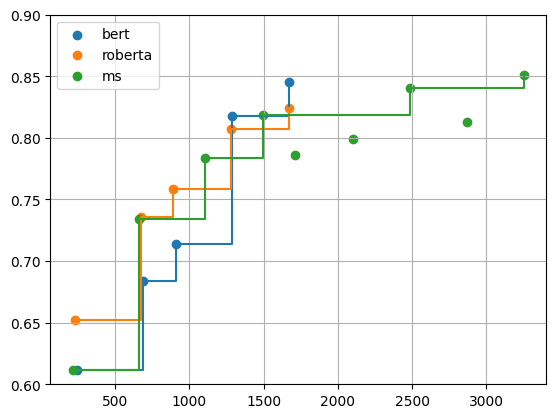

In [ ]:
from flaml.data import get_output_from_log
import matplotlib.pyplot as plt
import numpy as np

axs = []
for each_file_name in ['bert', 'roberta', 'ms']:
    time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
        get_output_from_log(filename='spooky_' + each_file_name + '.log', time_budget=4000)
    print(len(valid_loss_history))
    axs.append(plt.scatter(time_history, 1 - np.array(valid_loss_history)))
    plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')

plt.legend(handles=axs, labels=['bert', 'roberta', 'ms'])
plt.ylim([0.6, 0.9])
plt.grid()
plt.show()

## 4. Other Tasks

Besides sequence classification, FLAML currently also supports four other tasks (more tasks are to be supported, which can be found on [FLAML's documentation website](https://microsoft.github.io/FLAML/docs/Examples/AutoML-NLP)):

- sequence regression: predicting a float number from the input sequence, e.g., predicting the rating of a hotel review based on the text content;
- token classification: predicting the label of each token in a sequence, e.g., named entity recognition;
- multiple choice: predicting the best second half of a sentence that comes next to the first part of a sentence based on common sensen reasoning. An example is seen below;
- (abstractive) summarization: generating the textual summarization of an input paragraph;

Here we look into two tasks: multiple choice classification and text summarization. These tasks require significant computational resources, therefore instead of Colab, we run them using 4 NVIDIA V100 GPUs and Ray Tune on our server.

### 4.1 Multiple Choice Example

Multiple choice is a task of predicting the best second half of a sentence that follows the first half based on common sense reasoning. An example of multiple-choice classification problem is:

On stage, a woman takes a seat at the piano. She
a) sits on a bench as her sister plays with the doll.
b) smiles with someone as the music plays.
c) is in the crowd, watching the dancers.
d) *nervously sets her fingers on the keys*.

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("swag", split="train").to_pandas()[:2000]
dev_dataset = load_dataset("swag", split="validation").to_pandas()[:1000]
test_dataset = load_dataset("swag", split="test").to_pandas()

custom_sent_keys = [
        "sent1",
        "sent2",
        "ending0",
        "ending1",
        "ending2",
        "ending3",
        "gold-source",
        "video-id",
        "startphrase",
        "fold-ind",
    ]                                                  # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

print(len(X_train))
print(len(X_val))

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/73546 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20006 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20005 [00:00<?, ? examples/s]

Dataset swag downloaded and prepared to /root/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c. Subsequent calls will reuse this data.


2000
1000


In [ ]:
train_dataset.iloc[0]["sent1"]

'Members of the procession walk down the street holding small horn brass instruments.'

In [ ]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

automl_settings = {
    "time_budget": 1800,                 # setting the time budget
    "task": "multichoice-classification",       # setting the task as multiplechoice-classification
    "fit_kwargs_by_estimator": {          # if model_path is not set, the default model is facebook/muppet-roberta-base: https://huggingface.co/facebook/muppet-roberta-base
        "transformer": {
            "output_dir": "data/output/",  # setting the output directory
            "model_path": "bert-base-uncased", # the batch size for validation (inference)
        }
    },
    "gpu_per_trial": 1,                 # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",    # set the file to save the log for HPO
    "log_type": "all",                  # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": False,                    # set whether to use Ray
    "n_concurrent_trials": 1,
    "fp16": False
}

from flaml import tune
custom_hp = {
    "transformer": {
            "per_device_train_batch_size": {
                "domain": tune.choice([1, 2, 4]),
                "init_value": 4,
                "low_cost_init_value": 4,
            },
        }
}

'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, custom_hp=custom_hp, **automl_settings)

[flaml.automl.logger: 04-12 15:20:37] {1768} INFO - task = multichoice-classification
[flaml.automl.logger: 04-12 15:20:37] {1775} INFO - Data split method: stratified
[flaml.automl.logger: 04-12 15:20:37] {1778} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-12 15:20:37] {1891} INFO - Minimizing error metric: 1-accuracy


/usr/local/lib/python3.9/dist-packages/flaml/automl/data.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[str_columns] = X[str_columns].astype("string")


[flaml.automl.logger: 04-12 15:20:37] {2011} INFO - List of ML learners in AutoML Run: ['transformer']
[flaml.automl.logger: 04-12 15:20:37] {2341} INFO - iteration 0, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 1.0387, 'learning_rate': 6.666666666666666e-06, 'epoch': 1.0}
{'loss': 0.5781, 'learning_rate': 3.333333333333333e-06, 'epoch': 2.0}
{'eval_loss': 0.8650197982788086, 'eval_automl_metric': 0.29300000000000004, 'eval_runtime': 14.2894, 'eval_samples_per_second': 69.982, 'eval_steps_per_second': 69.982, 'epoch': 2.0}
{'loss': 0.363, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 0.9072939157485962, 'eval_automl_metric': 0.29100000000000004, 'eval_runtime': 13.6284, 'eval_samples_per_second': 73.376, 'eval_steps_per_second': 73.376, 'epoch': 3.0}
{'train_runtime': 270.546, 'train_samples_per_second': 22.177, 'train_steps_per_second': 5.544, 'train_loss': 0.659941151936849, 'epoch': 3.0}
[flaml.automl.logger: 04-12 15:25:50] {2479} INFO - Estimated sufficient time budget=3129882s. Estimated necessary time budget=3130s.
[flaml.automl.logger: 04-12 15:25:50] {2526} INFO -  at 313.1s,	estimator transformer's best error=0.2910,	best estimator transformer's best error=0.2910
[flaml.

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 1.0538, 'learning_rate': 6.474576669243438e-06, 'epoch': 1.0}
{'loss': 0.6091, 'learning_rate': 3.237288334621719e-06, 'epoch': 2.0}
{'eval_loss': 0.859893798828125, 'eval_automl_metric': 0.30200000000000005, 'eval_runtime': 13.9904, 'eval_samples_per_second': 71.477, 'eval_steps_per_second': 71.477, 'epoch': 2.0}
{'loss': 0.3889, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 0.8932241201400757, 'eval_automl_metric': 0.30800000000000005, 'eval_runtime': 13.5564, 'eval_samples_per_second': 73.766, 'eval_steps_per_second': 73.766, 'epoch': 3.0}
{'train_runtime': 268.5443, 'train_samples_per_second': 22.343, 'train_steps_per_second': 5.586, 'train_loss': 0.6839515177408854, 'epoch': 3.0}
[flaml.automl.logger: 04-12 15:30:44] {2526} INFO -  at 607.4s,	estimator transformer's best error=0.2910,	best estimator transformer's best error=0.2910
[flaml.automl.logger: 04-12 15:30:44] {2341} INFO - iteration 2, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 1.0315, 'learning_rate': 6.864455657088979e-06, 'epoch': 1.0}
{'loss': 0.5715, 'learning_rate': 3.4322278285444894e-06, 'epoch': 2.0}
{'eval_loss': 0.786681056022644, 'eval_automl_metric': 0.28500000000000003, 'eval_runtime': 14.1835, 'eval_samples_per_second': 70.505, 'eval_steps_per_second': 70.505, 'epoch': 2.0}
{'loss': 0.3374, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 0.8425467610359192, 'eval_automl_metric': 0.28700000000000003, 'eval_runtime': 13.4773, 'eval_samples_per_second': 74.199, 'eval_steps_per_second': 74.199, 'epoch': 3.0}
{'train_runtime': 268.049, 'train_samples_per_second': 22.384, 'train_steps_per_second': 5.596, 'train_loss': 0.6467840881347656, 'epoch': 3.0}
[flaml.automl.logger: 04-12 15:35:38] {2526} INFO -  at 901.2s,	estimator transformer's best error=0.2850,	best estimator transformer's best error=0.2850
[flaml.automl.logger: 04-12 15:35:38] {2341} INFO - iteration 3, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.9884, 'learning_rate': 7.3999972918443325e-06, 'epoch': 1.0}
{'eval_loss': 0.7787197828292847, 'eval_automl_metric': 0.29300000000000004, 'eval_runtime': 13.7995, 'eval_samples_per_second': 72.466, 'eval_steps_per_second': 72.466, 'epoch': 1.0}
{'loss': 0.4754, 'learning_rate': 0.0, 'epoch': 2.0}
{'eval_loss': 0.8423631191253662, 'eval_automl_metric': 0.28700000000000003, 'eval_runtime': 13.2491, 'eval_samples_per_second': 75.477, 'eval_steps_per_second': 75.477, 'epoch': 2.0}
{'train_runtime': 190.5498, 'train_samples_per_second': 20.992, 'train_steps_per_second': 5.248, 'train_loss': 0.7318977355957031, 'epoch': 2.0}
[flaml.automl.logger: 04-12 15:39:15] {2526} INFO -  at 1117.8s,	estimator transformer's best error=0.2850,	best estimator transformer's best error=0.2850
[flaml.automl.logger: 04-12 15:39:15] {2341} INFO - iteration 4, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 1.0922, 'learning_rate': 5.372722783974802e-06, 'epoch': 1.0}
{'loss': 0.66, 'learning_rate': 3.5818151893165346e-06, 'epoch': 2.0}
{'loss': 0.4378, 'learning_rate': 1.7909075946582673e-06, 'epoch': 3.0}
{'eval_loss': 0.8736429214477539, 'eval_automl_metric': 0.29300000000000004, 'eval_runtime': 14.0322, 'eval_samples_per_second': 71.265, 'eval_steps_per_second': 71.265, 'epoch': 3.0}
{'loss': 0.3225, 'learning_rate': 0.0, 'epoch': 4.0}
{'eval_loss': 0.9011046290397644, 'eval_automl_metric': 0.29200000000000004, 'eval_runtime': 13.052, 'eval_samples_per_second': 76.616, 'eval_steps_per_second': 76.616, 'epoch': 4.0}
{'train_runtime': 344.1498, 'train_samples_per_second': 23.246, 'train_steps_per_second': 5.811, 'train_loss': 0.6281196594238281, 'epoch': 4.0}
[flaml.automl.logger: 04-12 15:45:25] {2526} INFO -  at 1487.7s,	estimator transformer's best error=0.2850,	best estimator transformer's best error=0.2850
[flaml.automl.logger: 04-12 15:45:25] {2341} INFO - iteration 5, cu

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 1.1162, 'learning_rate': 1.192849707902046e-05, 'epoch': 1.0}
{'loss': 0.5407, 'learning_rate': 5.96424853951023e-06, 'epoch': 2.0}
{'eval_loss': 1.1717097759246826, 'eval_automl_metric': 0.375, 'eval_runtime': 13.9408, 'eval_samples_per_second': 71.732, 'eval_steps_per_second': 71.732, 'epoch': 2.0}
{'loss': 0.2207, 'learning_rate': 0.0, 'epoch': 3.0}
{'eval_loss': 1.4500138759613037, 'eval_automl_metric': 0.366, 'eval_runtime': 13.1329, 'eval_samples_per_second': 76.145, 'eval_steps_per_second': 76.145, 'epoch': 3.0}
{'train_runtime': 267.6649, 'train_samples_per_second': 22.416, 'train_steps_per_second': 5.604, 'train_loss': 0.6258482004801432, 'epoch': 3.0}
[flaml.automl.logger: 04-12 15:50:19] {2526} INFO -  at 1781.7s,	estimator transformer's best error=0.2850,	best estimator transformer's best error=0.2850
[flaml.automl.logger: 04-12 15:50:19] {2642} INFO - selected model: None
[flaml.automl.logger: 04-12 15:50:19] {2041} INFO - fit succeeded
[flaml.automl.logger: 04-12

{'Current Learner': 'transformer', 'Current Sample': 2000, 'Current Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'seed': 20, 'global_max_steps': 1500}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'seed': 20, 'global_max_steps': 1500}}
{'Current Learner': 'transformer', 'Current Sample': 2000, 'Current Hyper-parameters': {'learning_rate': 9.711865003865157e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'seed': 14, 'global_max_steps': 1000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'seed': 20, 'global_max_steps': 1500}}
{'Current Learner': 'transformer', 'Current Sample': 2000, 'Current Hyper-parameters': {'learning_rate': 1.0296683485633468e-05, 'num_train_epochs': 3, 'per_device_tr

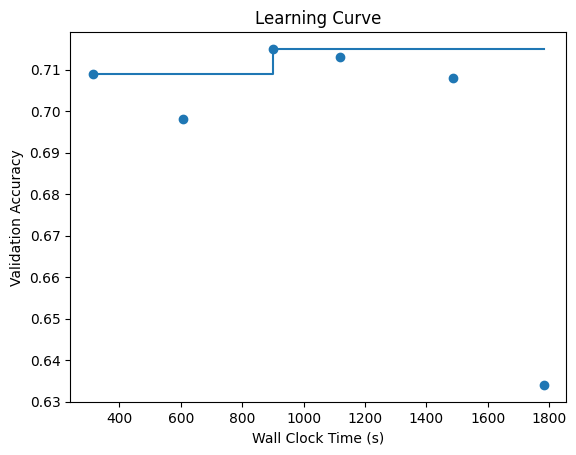

In [ ]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

### 4.2 Text Summarization Example

The text summarization task summarizes a long text into a short sentence. For example:

- Document: Army explosives experts were called out to deal with a suspect package at the offices on the Newtownards Road on Friday night. Roads were sealed off and traffic diverted as a controlled explosion was carried out. The premises, used by East Belfast MP Naomi Long, have been targeted a number of times. Most recently, petrol bomb attacks were carried out on the offices on consecutive nights in April and May. The attacks began following a Belfast City Council vote in December 2012 restricting the flying of the union flag at the City Hall. Condemning the latest hoax, Alliance MLA Chris Lyttle said: "It is a serious incident for the local area, it causes serious disruption, it puts people's lives at risk, it can prevent emergency services reaching the area. "Ultimately we need people with information to share that with the police in order for them to do their job and bring these people to justice.

- Summary: A suspicious package left outside an Alliance Party office in east Belfast has been declared a hoax.

In this example, we use FLAML to perform *abstractive summarization* using the t5-small language model, i.e., the summary is generated word-by-word. 

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("xsum", split="train").to_pandas()[:1000]
valid_dataset = load_dataset("xsum", split="validation").to_pandas()[:400]
test_dataset = load_dataset("xsum", split="test").to_pandas()

custom_sent_keys = ["document"]       # specify the column names of the input sentences
label_key = "summary"                 # specify the column name of the label                              

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = valid_dataset[custom_sent_keys], valid_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

print(len(train_dataset))
print(len(valid_dataset))

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71. Subsequent calls will reuse this data.


1000
400


In [ ]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray


automl_settings = {
    "time_budget": 1800,         # setting the time budget
    "task": "summarization",    # setting the task as summarization
    "fit_kwargs_by_estimator": {  # if model_path is not set, the default model is t5-small: https://huggingface.co/t5-small
        "transformer": {
            "output_dir": "data/output/",  # setting the output directory
            "model_path": "t5-small",
            "pad_to_max_length": True,
        }
    },
    "gpu_per_trial": 1,  # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",  # set the file to save the log for HPO
    "log_type": "all",   # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": False,  # set whether to use Ray
    "metric": "rouge1",
    "n_concurrent_trials": 1,  
    "fp16": False
}

from flaml import tune
custom_hp = {
    "transformer": {
            "num_train_epochs": {
                "domain": tune.choice([0.1, 1, 2, 3, 4, 5]),
                "init_value": 0.1,  
                "low_cost_init_value": 0.1,
            },
        }
}


'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, custom_hp=custom_hp, **automl_settings)

[flaml.automl.logger: 04-12 15:52:13] {1768} INFO - task = summarization
[flaml.automl.logger: 04-12 15:52:13] {1775} INFO - Data split method: uniform
[flaml.automl.logger: 04-12 15:52:13] {1778} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-12 15:52:13] {1891} INFO - Minimizing error metric: rouge1
[flaml.automl.logger: 04-12 15:52:13] {2011} INFO - List of ML learners in AutoML Run: ['transformer']
[flaml.automl.logger: 04-12 15:52:13] {2341} INFO - iteration 0, current learner transformer


/usr/local/lib/python3.9/dist-packages/flaml/automl/data.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[str_columns] = X[str_columns].astype("string")


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.9/dist-packages/flaml/automl/ml.py:209: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric(datasets_metric_name)


{'eval_loss': 4.139829158782959, 'eval_automl_metric': 0.861043247562474, 'eval_runtime': 88.7601, 'eval_samples_per_second': 4.507, 'eval_steps_per_second': 4.507, 'epoch': 0.12}
{'train_runtime': 93.8448, 'train_samples_per_second': 1.066, 'train_steps_per_second': 0.043, 'train_loss': 4.210696220397949, 'epoch': 0.12}


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

[flaml.automl.logger: 04-12 15:55:25] {2479} INFO - Estimated sufficient time budget=1915790s. Estimated necessary time budget=1916s.
[flaml.automl.logger: 04-12 15:55:25] {2526} INFO -  at 191.6s,	estimator transformer's best error=0.8610,	best estimator transformer's best error=0.8610
[flaml.automl.logger: 04-12 15:55:25] {2341} INFO - iteration 1, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

{'eval_loss': 4.153659820556641, 'eval_automl_metric': 0.8610390521300715, 'eval_runtime': 83.9022, 'eval_samples_per_second': 4.767, 'eval_steps_per_second': 4.767, 'epoch': 0.12}
{'train_runtime': 88.4476, 'train_samples_per_second': 1.131, 'train_steps_per_second': 0.023, 'train_loss': 4.123888969421387, 'epoch': 0.12}


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

[flaml.automl.logger: 04-12 15:58:24] {2526} INFO -  at 370.6s,	estimator transformer's best error=0.8610,	best estimator transformer's best error=0.8610
[flaml.automl.logger: 04-12 15:58:24] {2341} INFO - iteration 2, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

{'eval_loss': 4.139829158782959, 'eval_automl_metric': 0.861043247562474, 'eval_runtime': 81.3582, 'eval_samples_per_second': 4.917, 'eval_steps_per_second': 4.917, 'epoch': 0.12}
{'train_runtime': 85.9738, 'train_samples_per_second': 1.163, 'train_steps_per_second': 0.047, 'train_loss': 4.210696220397949, 'epoch': 0.12}


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

[flaml.automl.logger: 04-12 16:01:21] {2526} INFO -  at 547.4s,	estimator transformer's best error=0.8610,	best estimator transformer's best error=0.8610
[flaml.automl.logger: 04-12 16:01:21] {2341} INFO - iteration 3, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

{'eval_loss': 4.143656253814697, 'eval_automl_metric': 0.8608808953259102, 'eval_runtime': 80.6625, 'eval_samples_per_second': 4.959, 'eval_steps_per_second': 4.959, 'epoch': 0.12}
{'train_runtime': 85.1755, 'train_samples_per_second': 1.174, 'train_steps_per_second': 0.023, 'train_loss': 4.254851341247559, 'epoch': 0.12}


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

[flaml.automl.logger: 04-12 16:04:17] {2526} INFO -  at 723.4s,	estimator transformer's best error=0.8609,	best estimator transformer's best error=0.8609
[flaml.automl.logger: 04-12 16:04:17] {2341} INFO - iteration 4, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

{'eval_loss': 4.041061878204346, 'eval_automl_metric': 0.8605258085686105, 'eval_runtime': 81.8821, 'eval_samples_per_second': 4.885, 'eval_steps_per_second': 4.885, 'epoch': 1.0}
{'train_runtime': 100.4684, 'train_samples_per_second': 9.953, 'train_steps_per_second': 0.159, 'train_loss': 4.15610408782959, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

[flaml.automl.logger: 04-12 16:07:29] {2526} INFO -  at 915.9s,	estimator transformer's best error=0.8605,	best estimator transformer's best error=0.8605
[flaml.automl.logger: 04-12 16:07:29] {2341} INFO - iteration 5, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

{'eval_loss': 3.9432952404022217, 'eval_automl_metric': 0.8609624645900873, 'eval_runtime': 80.9141, 'eval_samples_per_second': 4.944, 'eval_steps_per_second': 4.944, 'epoch': 1.0}
{'train_runtime': 99.1635, 'train_samples_per_second': 10.084, 'train_steps_per_second': 0.161, 'train_loss': 4.104092121124268, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

[flaml.automl.logger: 04-12 16:10:40] {2526} INFO -  at 1106.4s,	estimator transformer's best error=0.8605,	best estimator transformer's best error=0.8605
[flaml.automl.logger: 04-12 16:10:40] {2341} INFO - iteration 6, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

{'eval_loss': 4.097936630249023, 'eval_automl_metric': 0.8612426478909745, 'eval_runtime': 80.6458, 'eval_samples_per_second': 4.96, 'eval_steps_per_second': 4.96, 'epoch': 1.0}
{'train_runtime': 99.0009, 'train_samples_per_second': 10.101, 'train_steps_per_second': 0.162, 'train_loss': 4.184399127960205, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

[flaml.automl.logger: 04-12 16:13:50] {2526} INFO -  at 1296.4s,	estimator transformer's best error=0.8605,	best estimator transformer's best error=0.8605
[flaml.automl.logger: 04-12 16:13:50] {2341} INFO - iteration 7, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

{'eval_loss': 3.8940911293029785, 'eval_automl_metric': 0.8598968257660171, 'eval_runtime': 80.9135, 'eval_samples_per_second': 4.944, 'eval_steps_per_second': 4.944, 'epoch': 1.0}
{'train_runtime': 99.2612, 'train_samples_per_second': 10.074, 'train_steps_per_second': 0.161, 'train_loss': 4.087018013000488, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

[flaml.automl.logger: 04-12 16:17:00] {2526} INFO -  at 1486.5s,	estimator transformer's best error=0.8599,	best estimator transformer's best error=0.8599
[flaml.automl.logger: 04-12 16:17:00] {2341} INFO - iteration 8, current learner transformer


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

{'eval_loss': 4.041061878204346, 'eval_automl_metric': 0.8605258085686105, 'eval_runtime': 81.0644, 'eval_samples_per_second': 4.934, 'eval_steps_per_second': 4.934, 'epoch': 1.0}
{'train_runtime': 98.6821, 'train_samples_per_second': 10.134, 'train_steps_per_second': 0.162, 'train_loss': 4.15610408782959, 'epoch': 1.0}


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` o

[flaml.automl.logger: 04-12 16:20:09] {2526} INFO -  at 1675.4s,	estimator transformer's best error=0.8599,	best estimator transformer's best error=0.8599
[flaml.automl.logger: 04-12 16:20:09] {2642} INFO - selected model: None
[flaml.automl.logger: 04-12 16:20:09] {2041} INFO - fit succeeded
[flaml.automl.logger: 04-12 16:20:09] {2042} INFO - Time taken to find the best model: 1486.497179031372
[flaml.automl.logger: 04-12 16:20:09] {2054} WARNING - Time taken to find the best model is 83% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


{'Current Learner': 'transformer', 'Current Sample': 1000, 'Current Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 0.1, 'per_device_train_batch_size': 32, 'seed': 20, 'global_max_steps': 4}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 9.999999999999999e-06, 'num_train_epochs': 0.1, 'per_device_train_batch_size': 32, 'seed': 20, 'global_max_steps': 4}}
{'Current Learner': 'transformer', 'Current Sample': 1000, 'Current Hyper-parameters': {'learning_rate': 9.711865003865157e-06, 'num_train_epochs': 0.1, 'per_device_train_batch_size': 64, 'seed': 14, 'global_max_steps': 2}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 9.711865003865157e-06, 'num_train_epochs': 0.1, 'per_device_train_batch_size': 64, 'seed': 14, 'global_max_steps': 2}}
{'Current Learner': 'transformer', 'Current Sample': 1000, 'Current Hyper-parameters': {'learning_rate': 9.999999999999997e-06, 'num_train_epochs': 0.1, 'per_device_t

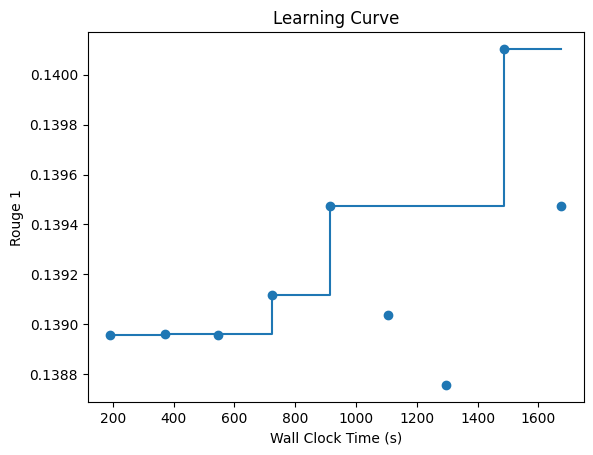

In [ ]:

from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Rouge 1')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()